## CS vs FS on synthetic conductive models
This study has been demonstrated in the EMagPy paper [McLachlan et al. (2021)](https://doi.org/10.1016/j.cageo.2020.104561).

Synthetic ECa values are generated using based on a two layer model without noise at 0 m and at 1 m above the ground using the coil orientation of the CMD Explorer. These ECa are then inverted using either the FSeq forward model or the CS.

The figure below shows the inverted models with (a) FSeq at 0 m, (b) FSeq at 1 m, (c) CS at 0 m, (d) CS at 1 m. The red lines denote the true interface between the two layers of 20 and 100 mS/m from top to bottom. The error bars show the standard deviation of the posterior distribution (based on the 10% best sample).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../src') # add path where emagpy is
from emagpy import Problem

datadir = '../src/examples/'

letters = ['a','b','c','d','e','f','g','h','i','j']

i 0 coils ['VCP1.48f10000h0', 'VCP2.82f10000h0', 'VCP4.49f10000h0', 'HCP1.48f10000h0', 'HCP2.82f10000h0', 'HCP4.49f10000h0']
Forward modelling
i 1 coils ['VCP1.48f10000h1', 'VCP2.82f10000h1', 'VCP4.49f10000h1', 'HCP1.48f10000h1', 'HCP2.82f10000h1', 'HCP4.49f10000h1']
Forward modelling
i 2 coils ['VCP1.48f10000h0', 'VCP2.82f10000h0', 'VCP4.49f10000h0', 'HCP1.48f10000h0', 'HCP2.82f10000h0', 'HCP4.49f10000h0']
Forward modelling
i 3 coils ['VCP1.48f10000h1', 'VCP2.82f10000h1', 'VCP4.49f10000h1', 'HCP1.48f10000h1', 'HCP2.82f10000h1', 'HCP4.49f10000h1']
Forward modelling
k.showResults()
k.show()


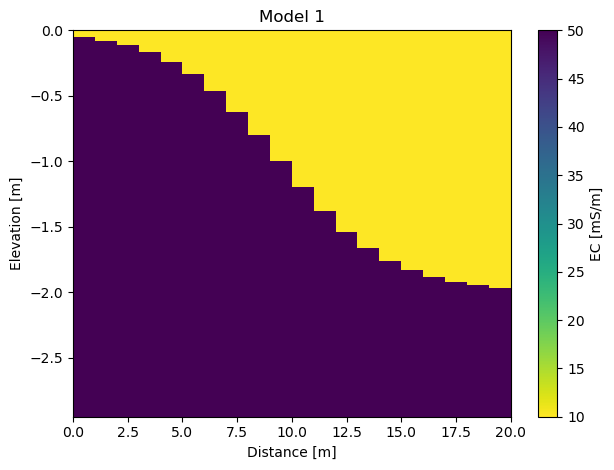

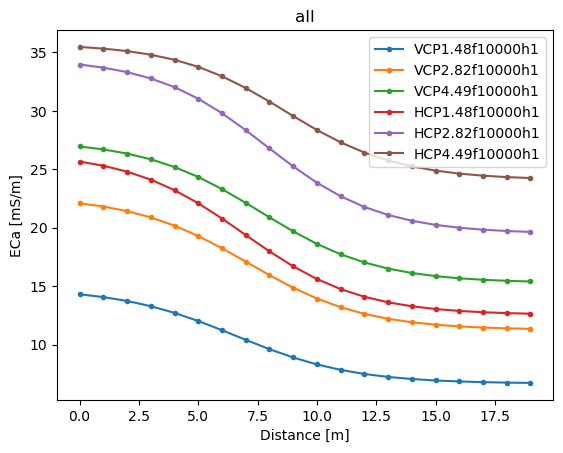

In [2]:
# parameters for the synthetic model
nlayer = 2 # number of layers
npos = 20 # number of positions/sampling locations
conds = np.ones((npos, nlayer))*[10, 50] # EC in mS/m
x = np.linspace(0.1, 2, npos)[:,None]
depths = 0 + 2/(1+np.exp(-4*(x-1))) # depth of model

# defines coils configuration, frequency and height above the ground
coils0 = ['VCP1.48f10000h0', 'VCP2.82f10000h0', 'VCP4.49f10000h0',
          'HCP1.48f10000h0', 'HCP2.82f10000h0', 'HCP4.49f10000h0']
coils1 = ['VCP1.48f10000h1', 'VCP2.82f10000h1', 'VCP4.49f10000h1',
          'HCP1.48f10000h1', 'HCP2.82f10000h1', 'HCP4.49f10000h1']

# foward modelling
ks = []
for i, coils in enumerate([coils0, coils1, coils0, coils1]):
    print('i', i, 'coils', coils)
    k = Problem()
    k.setModels([depths], [conds])
    _ = k.forward(forwardModel='FSlin', coils=coils, noise=0.0)
    ks.append(k)
    
print('k.showResults()')
k.showResults() # display original model

print('k.show()')
k.show() # display ECa computed from forward modelling

In [3]:
for k, fm in zip(ks, ['FSlin','FSlin','CS','CS']):
    k.setInit(depths0=[0.5], fixedDepths=[False],
              conds0=[20, 20], fixedConds=[False, False]) # set initial values
    # invert using ROPE solver (RObust Parameter Estimation)
    k.invert(forwardModel=fm, method='ROPE', regularization='l1', alpha=0,
             bnds=[(0.01, 3), (0, 80), (0, 80)], rep=3000, njobs=-1)

100%|██████████| 20/20 [00:00<00:00, 9985.25it/s]


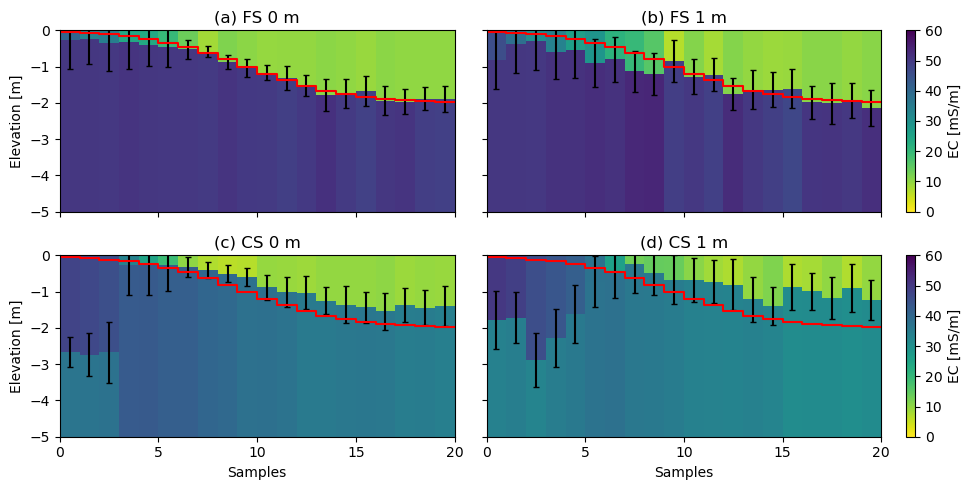

In [4]:
# figure
titles = ['(a) FS 0 m', '(b) FS 1 m', '(c) CS 0 m', '(d) CS 1 m']
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=True)
axs = axs.flatten()
for i, k in enumerate(ks):
    ax = axs[i]
    k.showResults(ax=ax, vmin=0, vmax=60, maxDepth=5, errorbar=True, dist=False)
    ax.step(-np.vstack([depths, depths[-1,:]]), 'r-', where='post')
    if i % 2 == 0:
        fig.axes[-1].remove() # remove colorbar
    else:
        ax.set_ylabel('')
    if i < 2:
        ax.set_xlabel('')
    ax.set_title(titles[i])
ax.set_xticks(np.arange(0, 21, 5))
fig.tight_layout()